In [1]:
import numpy as np
import pickle

from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
retrain = False

# Data

In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (2313665, 33)
y_train.shape = (2313665, 2)


# Parameter Optimization

In [4]:
RandomForestClassifier_parameters = {
    'n_jobs': 8,                # use 8 cores
    'random_state': 20210927    # with the same random state
}

In [5]:
hyperparameter_search_space = {
    'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200],
}

## Cross-Validation: Helper Functions

In [6]:
def get_mean_CV_Score(score_function, hyperparameters, y_label):
    assert y_label in ['hosp', 'death']
    y_index = 0 if y_label == 'hosp' else 1

    n_estimators, = hyperparameters

    kf = KFold(n_splits=5, shuffle=True, random_state=20210927)

    log_loss_list = np.empty(5, dtype=np.float64)

    for split_index, (fit_index, val_index) in enumerate(kf.split(X_train)):
        # create splits
        X_fit, X_val = X_train[fit_index], X_train[val_index]
        y_fit, y_val = y_train[fit_index], y_train[val_index]

        # scale features
        sc_X_fit = StandardScaler()
        X_fit_scaled = sc_X_fit.fit_transform(X_fit)
        X_val_scaled = sc_X_fit.transform(X_val)

        # create classifier
        rfc = RandomForestClassifier(**RandomForestClassifier_parameters, n_estimators=n_estimators)

        # fit
        rfc.fit(X_fit_scaled, y_fit[:, y_index])

        # evaluate
        y_pred_proba = rfc.predict_proba(X_val_scaled)
        log_loss_list[split_index] = score_function(y_val[:, y_index], y_pred_proba[:, 1])

    return np.mean(log_loss_list)

## Run Grid Search

In [7]:
# 2h on i7-6700k @ 4.4GHz
GP, Q, E = {}, {}, {}
for y_label in ['hosp', 'death']:
    if retrain:
        Q[y_label] = hyperparameter_search_space['n_estimators']
        E[y_label] = []

        for q in tqdm(Q[y_label]):
            E[y_label].append(get_mean_CV_Score(log_loss, (q, ), y_label))

        print('Completed Optimization')
        print('Storing Results...')
        with open(f'../hyperparameter_results/RF_{y_label}.pt', 'wb') as file:
            pickle.dump((Q[y_label], E[y_label]), file)
        print('Stored Results')

    else:
        print(f'Loading Results ({y_label})...')
        with open(f'../hyperparameter_results/RF_{y_label}.pt', 'rb') as file:
            Q[y_label], E[y_label] = pickle.load(file)
        print(f'Loaded Results ({y_label})')

Loading Results (hosp)...
Loaded Results (hosp)
Loading Results (death)...
Loaded Results (death)


## Grid Search Crossvalidation Results

In [8]:
n_estimators_linspace = np.linspace(np.min(hyperparameter_search_space['n_estimators']) * 0.9, np.max(hyperparameter_search_space['n_estimators']) * 1.1, 1000)

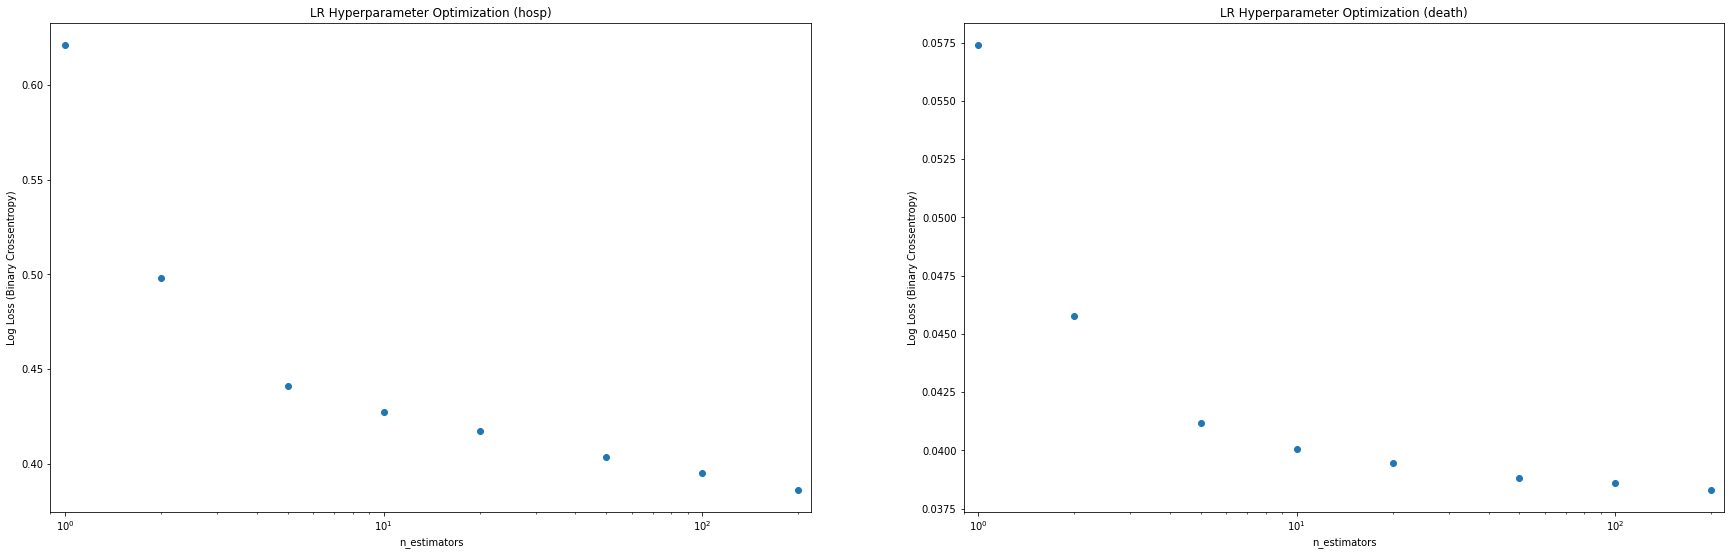

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(30, 9))

for i, y_label in enumerate(['hosp', 'death']):
    axes[i].scatter(Q[y_label], E[y_label], color='tab:blue')
    axes[i].set_xscale('log'); axes[i].set_xlim(np.min(n_estimators_linspace), np.max(n_estimators_linspace))
    axes[i].set_xlabel('n_estimators'); axes[i].set_ylabel('Log Loss (Binary Crossentropy)'); axes[i].set_title(f'LR Hyperparameter Optimization ({y_label})')

In [10]:
# define limit based on sensible training time

best_hyperparameters = {
    'hosp': {
        'n_estimators': 200
    },
    'death': {
        'n_estimators': 100
    }
}

# Final Training

In [11]:
# scale features
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

# create classifier
rf = {y_label: RandomForestClassifier(**RandomForestClassifier_parameters, **best_hyperparameters[y_label]) for y_label in ['hosp', 'death']}

# fit
for i, y_label in enumerate(tqdm(['hosp', 'death'])):
    rf[y_label].fit(X_train_scaled, y_train[:, i]);

100%|██████████| 2/2 [07:20<00:00, 220.14s/it]


# Evaluation on Test Set

In [12]:
with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = sc_X_train.transform(X_test)

X_test.shape = (578417, 33)
y_test.shape = (578417, 2)


In [13]:
evaluation_results = {}

for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')

    y_pred_proba = rf[y_label].predict_proba(X_test_scaled)
    evaluation_results[y_label] = y_pred_proba
    y_pred = rf[y_label].predict(X_test_scaled)

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], y_pred_proba[:, 1]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], y_pred_proba[:, 1]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], y_pred).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], y_pred))
    print()

--- hosp ---
binary cross-entropy: 0.3544
brier loss: 0.0529
accuracy: 0.9371
confusion matrix:
[[535926   3096]
 [ 33293   6102]]

--- death ---
binary cross-entropy: 0.0346
brier loss: 0.0087
accuracy: 0.9895
confusion matrix:
[[570438    261]
 [  5790   1928]]



In [14]:
with open('../evaluation_results/predictions/RF.pt', 'wb') as file:
    pickle.dump(evaluation_results, file)

# Observations

more false negatives than false positives. Slightly better accuracy than SVC and LR.